# Autoencoders

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from tqdm import tqdm

Autoencoders (AEs) are a type of neural network architecture designed to learn efficient data representations, primarily for the purpose of dimensionality reduction or feature learning, making AEs able to find a compressed representation of the input data such as image, video, text, speech, etc. By doing this, the autoencoder learns to extract the most important features of the input data and represent it in a lower-dimensional space. This compressed representation, also known as the "latent space", is typically of lower dimensionality than the original input data, which allows for more efficient storage and processing of the data. The goal of an autoencoder is to learn a compressed representation of the input data and use that compressed representation to reconstruct the original input data as closely as possible, while minimizing the reconstruction error.

**Architecture of autoencoders:** Autoencoder consists of two main types of networks parts: an encoder and a decoder. The encoder takes in an input data sample and maps it to a lower-dimensional latent representation, also known as a code or bottleneck because it compresses the input data while retaining its important features. The size of the bottleneck, also known as the encoding dimension, is a hyperparameter that is set before the training of the model and it's usually smaller than the size of the original input data. The decoder then takes this lower-dimensional representation and maps it back to the original input data space, reconstructing the input data as closely as possible. However, it is important to note that this reconstruction is lossy, meaning that the reconstructed output may not be an exact copy of the original input. This is because the autoencoder is trained to minimize the reconstruction error, which measures the difference between the original input and the reconstructed output. Therefore, the reconstructed output may have some loss of information compared to the original input.

In [ ]:
# setting the device
device= 'cuda' if torch.cuda.is_available() else 'cpu'

# Data processing

The pixel values fall in the range of 0 to 255. As a preprocessing step, these pixel values are normalized to fall from 0 to 1. This is achieved by dividing each pixel value by 255. This normalization helps in faster and more stable convergence during training.

In [ ]:
# calling the dataset
from tensorflow.keras.datasets import mnist

# access the training and test data
(Xtr_raw, Ytr_raw), (Xte_raw, Yte_raw)= mnist.load_data()

# data reformating - adding a channel dimension
Xtr_raw= np.expand_dims(Xtr_raw, 1) # Grayscale images have 1 channel
Xte_raw= np.expand_dims(Xte_raw, 1)

# convert data to float32
Xtr_raw= Xtr_raw.astype(np.float32)
Xte_raw= Xte_raw.astype(np.float32)


IMG_MAXVAL= 255.0

# normalizing the training data
Xtr_raw /= IMG_MAXVAL

# normalizing the test data
Xte_raw /= IMG_MAXVAL


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# converting data to pytorch type
Xtr= torch.tensor(Xtr_raw, requires_grad=True).to(device)
Ytr= torch.tensor(Ytr_raw).to(device)
Xte= torch.tensor(Xte_raw, requires_grad=True).to(device)
Yte= torch.tensor(Yte_raw).to(device)

# transforming labels from numbers to one-hot vectors of length 10
Ytr= F.one_hot(Ytr.type(torch.int64), num_classes=10).type(torch.float32)
Yte= F.one_hot(Yte.type(torch.int64), num_classes=10).type(torch.float32)

# creating a dev dataset from training data
tr_size= int(0.8*Xtr.shape[0])

Xdev= Xtr[tr_size:]
Ydev= Ytr[tr_size:]

Xtr= Xtr[:tr_size]
Ytr= Ytr[:tr_size]

print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of dev data: Xdev - {Xdev.shape}, Ydev - {Ydev.shape}')
print(f'Shape of test data: Xte - {Xte.shape}, Yte - {Yte.shape}')

Shape of training: Xtr - torch.Size([48000, 1, 28, 28]), Ytr - torch.Size([48000, 10])
Shape of dev data: Xdev - torch.Size([12000, 1, 28, 28]), Ydev - torch.Size([12000, 10])
Shape of test data: Xte - torch.Size([10000, 1, 28, 28]), Yte - torch.Size([10000, 10])


Unsupervised learning and Autoencoders:

https://www.youtube.com/watch?v=ekyBklxwQMU 32:05min

**Unsupervised feature learning:** After training the Autoencoder, we can throw away the decoder, refresh the FC network of at the end of the encoder and fine tune it as as classifier (updating the code hear to something like the backbone-head archtecture we implemented for SSL).

Therefore, Autoencoders can reconstruct data and can learn features to initialize a supervised model. We can also use them to generate data by learning probability distributions about our data (latent spaces) and how probability distributions can fit together to generate datasets.

# Contractive autoencoder

It is a type of AE where the regularization term is based on the contractive property. The contractive property refers to the fact that Contractive autoencoders work on the basis that similar inputs should have similar encodings and a similar latent space representation. It means that the latent space should not vary by a huge amount for minor variations in the input. Therefore, a contractive autoencoder (CAE) is designed to learn a compressed representation of the input data that is insensitive to small perturbations. As a result, the encoding layer "contracts" the input data into a compressed representation that captures the essential features of the data.

https://medium.com/@ompramod9921/autoencoders-explained-a223a5268618

In [ ]:
class Encoder(nn.Module):
    """
    Define the encoder.
    """

    def __init__(self, image_size, input_chs, hidden_chs, output_chs,
                 kernels=3, paddings=1, max_pools=2, embedding_dim=1) -> None:
        super(Encoder, self).__init__()
        # convolutional layers
        self.conv_in= nn.Conv2d(input_chs, hidden_chs[0], kernels, padding=paddings)
        self.m_pool1= nn.MaxPool2d(max_pools)
        self.activ1= nn.ReLU()

        self.conv_hn= nn.Conv2d(hidden_chs[0], hidden_chs[1], kernels, padding=paddings)
        self.m_pool2= nn.MaxPool2d(max_pools)
        self.activ2= nn.ReLU()

        self.conv_out= nn.Conv2d(hidden_chs[1], output_chs, kernels, padding=paddings)
        self.m_pool3= nn.MaxPool2d(max_pools)
        self.activ3= nn.ReLU()

        self.flatten= nn.Flatten()
        # compute the flattened size after convolutions
        self.flat_size= ((image_size//(max_pools**3))**2) * output_chs
        # fully connected layer to create embeddings
        self.fc_out= nn.Linear(self.flat_size, embedding_dim)

        for p in self.parameters():
            if p.dim()> 1:
                nn.init.kaiming_normal_(p, nonlinearity='relu')


    def forward(self, x):
        x= self.activ1(self.m_pool1(self.conv_in(x)))
        x= self.activ2(self.m_pool2(self.conv_hn(x)))
        x= self.activ3(self.m_pool3(self.conv_out(x)))
        x= self.fc_out(self.flatten(x))

        return x


Upsampling and convolution transpose:

https://www.youtube.com/watch?v=ByjaPdWXKJ4 17:00min


In [ ]:
class Decoder(nn.Module):
    """
    Define the decoder.
    """

    def __init__(self, embedding_dim, output_linear,
                 input_chs, hidden_chs, output_chs, kernels=3, paddings=1, strides=2) -> None:
        super(Decoder, self).__init__()
        # fully connected layer to reshape flatten tensor to 2D tensor
        self.fc_in= nn.Linear(embedding_dim, output_linear)
        unflat_size= int((output_linear // input_chs)**0.5)
        unflat_dims= torch.Size([input_chs, unflat_size, unflat_size])
        self.make2d= nn.Unflatten(1, unflat_dims)

        # convT layers -- in_channels, out_channels, kernel_size, stride, padding, output_padding
        self.convT_in= nn.ConvTranspose2d(input_chs, input_chs, kernels, strides, paddings, paddings)
        self.activ1= nn.ReLU()
        self.convT_hn= nn.ConvTranspose2d(input_chs, hidden_chs[0], kernels, strides, paddings-1, paddings)
        self.activ2= nn.ReLU()
        self.convT_out= nn.ConvTranspose2d(hidden_chs[0], hidden_chs[1], kernels, strides, paddings, paddings)
        self.activ3= nn.ReLU()
        # final convolutional layer to generate output image
        self.conv_out= nn.Conv2d(hidden_chs[1], output_chs, kernels, padding=paddings)

        for p in self.parameters():
            if p.dim()> 1:
                nn.init.kaiming_normal_(p, nonlinearity='relu')


    def forward(self, x):
        x= self.make2d(self.fc_in(x))
        x= self.activ1(self.convT_in(x))
        x= self.activ2(self.convT_hn(x))
        x= self.activ3(self.convT_out(x))
        x= self.conv_out(x)

        return F.sigmoid(x)


In [ ]:
# https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/

In [ ]:
class Autoencoder(nn.Module):
    """
    Define the autoencoder (encoder-decoder) model.
    """

    def __init__(self, image_size, input_chs, hidden_chs, output_chs, embedding_dim,
                 kernels=3, paddings=1, max_pools=2) -> None:
        super(Autoencoder, self).__init__()
        self.encoder= Encoder(
            image_size, input_chs, hidden_chs, output_chs, kernels, paddings, max_pools, embedding_dim
        )

        dec_input_chs= output_chs
        dec_hidden_chs= hidden_chs[::-1]
        dec_output_chs= input_chs
        dec_strides= max_pools

        self.decoder= Decoder(
            embedding_dim, self.encoder.flat_size, dec_input_chs, dec_hidden_chs, dec_output_chs,
            kernels, paddings, dec_strides
        )


    def encode(self, x):
        encoded= self.encoder(x)

        return encoded


    def decode(self, x):
        decoded= self.decoder(x)

        return decoded


    def forward(self, x):
        encoded= self.encode(x)
        decoded= self.decode(encoded)

        return encoded, decoded


In [ ]:
# encoder defs
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
kernels=3
paddings=1
max_pools=2
embedding_dim= 64

enc_model= Encoder(image_size, input_chs, hidden_chs, output_chs, kernels, paddings, max_pools,
                   embedding_dim).to(device)

# Encode a sample image and generate a latent vector
y_enc= enc_model(Xtr[:1])
y_enc.shape

torch.Size([1, 64])

In [ ]:
# decoder defs
embedding_dim= y_enc.shape[1]
output_linear= enc_model.flat_size
input_chs= 128
hidden_chs= [64,32]
output_chs= Xtr.shape[1]
kernels=3
paddings=1
strides= max_pools

dec_model= Decoder(embedding_dim, output_linear,
                   input_chs, hidden_chs, output_chs, kernels, paddings, strides).to(device)

# Decode a latent vector
y_dec= dec_model(y_enc)
y_dec.shape

torch.Size([1, 1, 28, 28])

In [ ]:
# autoencoder defs
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
embedding_dim= 64
kernels=3
paddings=1
max_pools=2

ae_model= Autoencoder(image_size, input_chs, hidden_chs, output_chs, embedding_dim,
                      kernels, paddings, max_pools).to(device)

# Encode a sample image and decode its latent vector
y_en, y_ae= ae_model(Xtr[:1])
y_en.shape, y_ae.shape

(torch.Size([1, 64]), torch.Size([1, 1, 28, 28]))

In [ ]:
total_params= sum(p.numel() for p in ae_model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

ae_model

Number of parameters: 481473


Autoencoder(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ1): ReLU()
    (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ2): ReLU()
    (conv_out): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc_out): Linear(in_features=1152, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc_in): Linear(in_features=64, out_features=1152, bias=True)
    (make2d): Unflatten(dim=1, unflattened_size=torch.Size([128, 3, 3]))
    (convT_in): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=

# Contractive Loss

In the context of machine learning, perturbations refer to small changes or variations made to the input data in order to study the behaviour of a model or to improve its robustness by testing its ability to generalize to slightly different inputs. These perturbations can be intentional or random, and can be applied to different types of data, such as images, text, and numerical data. For example, in the context of image classification, perturbations can be applied to an image by adding small amounts of noise or changing the brightness, contrast, or orientation of the image. By doing so, we can study how the classification model responds to different types of input variations and assess its robustness to different types of noise or image transformations.

This is achieved by adding a penalty term to the loss function that measures the sensitivity of the encoding layer to small changes in the input data. The total loss function of a contractive autoencoder is a combination of two terms: the reconstruction loss ($L_{recon}$) and a regularization term ($\lambda * ||J_f(x)||^2$). The reconstruction loss is the same as in a standard autoencoder and measures the difference between the input and the reconstructed output. The regularization term, on the other hand, penalizes the encoding layer for being too sensitive to small changes in the input data.

The squared Frobenius norm of the Jacobian matrix measures the sensitivity of the encoding layer to small changes in the input data. A higher norm value implies that the encoding layer is more sensitive to input perturbations, and a lower norm value implies that the encoding layer is more robust to input variations. Therefore, minimizing the squared Frobenius norm encourages the encoding layer to learn a more robust representation of the input data.

In [ ]:
class ContractiveAutoencoderLoss(nn.Module):
    """
    Define the contractive autoencoder loss function.
    """

    def __init__(self, penalty_lambda=1e-4) -> None:
        super().__init__()
        self.penalty_lambda= penalty_lambda


    def forward(self, y_pred_enc, y_pred, y_true):
        # calculate the reconstruction loss
        reconstruction_loss_fn= nn.MSELoss()
        reconstruction_loss= reconstruction_loss_fn(y_pred, y_true)

        # calculate the contractive penalty
        y_pred_enc.backward(torch.ones(y_pred_enc.size()).to(device), retain_graph=True)
        # Frobenius norm - the square root of the sum of the squares of all the Jacobian matrix entries
        contractive_penalty= torch.sqrt(torch.sum(torch.pow(y_true.grad, 2)))
        y_true.grad.data.zero_()

        loss= reconstruction_loss + self.penalty_lambda * contractive_penalty

        return loss   # return the total loss


In [ ]:
# https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch

# Train the Autoencoder

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def c_autoencoder_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                           batch_size=64, shuffle:bool=True, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_tr_fn= ContractiveAutoencoderLoss().forward
    loss_ev_fn= nn.MSELoss()

    # for decreasing learning rate
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]
            Xmb.retain_grad()

            # --- forward pass and get loss ---
            model.train(True)
            y_enc, y_enc_dec= model(Xmb)
            loss_tr= loss_tr_fn(y_enc, y_enc_dec, Xmb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                _, y_enc_dec= model(Xdev)
                loss_dev= loss_ev_fn(y_enc_dec, Xdev)

        dev_hist.append(loss_dev.item())
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [ ]:
def eval_autoencoder(model, test_data, loss_fn=nn.MSELoss()):

    model.train(False)
    with torch.no_grad():
        _, y_enc_dec= model(test_data)
        loss_test= loss_fn(y_enc_dec, test_data)

    return loss_test.item()


In [ ]:
"""
Reseting the Autoencoder model for contractive training.
"""

ae_model= Autoencoder(image_size, input_chs, hidden_chs, output_chs, embedding_dim,
                      kernels, paddings, max_pools).to(device)

train_hist, dev_hist, schedule_hist= c_autoencoder_training(ae_model, learning_rate=1e-3, epochs=30,
                                                            batch_size=250, eval_interval=2, cutoff=1e-4)


100%|██████████| 30/30 [38:57<00:00, 77.92s/it]


In [ ]:
eval_autoencoder(ae_model, Xte)

0.010506288148462772

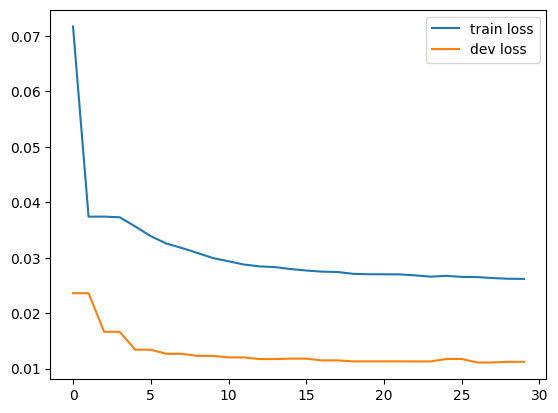

In [ ]:
# ploting

plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

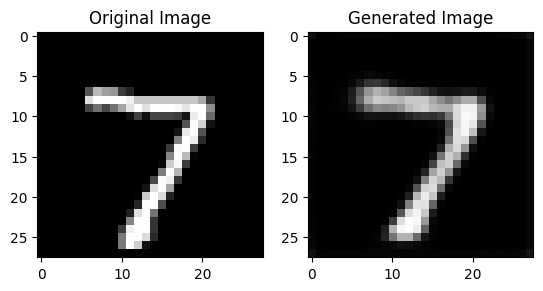

In [ ]:
# Select an image from the test set
img_index= 0
test_img= Xte[img_index:img_index+1]

latent_vector, generated_img= ae_model(test_img)


# Plot the original image and the generated image
plt.subplot(1, 2, 1)
plt.imshow(test_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(generated_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Generated Image')

plt.show()

# Denoising Autoencoders

In traditional autoencoders, the goal is to learn a compressed representation that preserves the essential information in the data. However, if the input data is noisy or corrupted, the autoencoder may learn to encode and decode the noise as well, resulting in a poor compressed representation. Denoising autoencoders address this problem by learning to denoise the input data during training.

One approach to encourage an autoencoder to learn a useful representation of data is to keep the code layer small. This forces the model to learn an intelligent representation of the data rather than simply copying the input to the output. Another approach is to add random noise to the input data and train the autoencoder to recover the original, noise-free data. This way the autoencoder can't simply copy the input to its output because the input also contains random noise. This technique is called a denoising autoencoder and helps ensure that the model is subtracting the noise and learning the underlying meaningful features of the data.

The amount and type of noise added can vary depending on the problem being solved. For example, in image denoising tasks, random noise can be added to the pixels of an image to create a noisy version of the image. The noise can be added in various ways, such as Gaussian noise, salt-and-pepper noise, or random pixel dropout. Similarly, in speech denoising tasks, random noise can be added to the audio signal to create a noisy version of the speech.

**Data augmentation by adding Gaussian noise**

In [ ]:
class NoiseAugment:
    """
    A data augmentation module based on adding Gaussian noise to images.
    """

    def __init__(self, sigma=0.1, norm=False) -> None:
        self.sigma= sigma
        self.norm = norm


    def __call__(self, x):
        # Generate Gaussian noise
        noise= torch.randn(size=x.shape).to(device)
        if self.norm:
            noise -= noise.amin(dim=(1,2,3), keepdim=True)
            noise /= noise.amax(dim=(1,2,3), keepdim=True)

        # Clip the images to be between 0 and 1
        return torch.clip((x + (self.sigma * noise)), min=0.0, max=1.0)


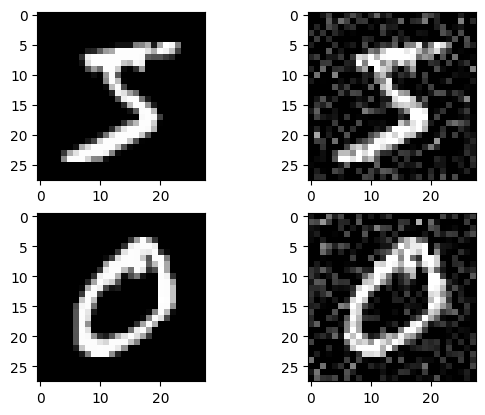

In [ ]:
# generating test augmentation
a= NoiseAugment(sigma=0.2, norm=False)
aug= a(Xtr[0:2])

f, axarr= plt.subplots(2, 2)

# original image - positive pair
axarr[0, 0].imshow(Xtr[0][0].cpu().detach().numpy(), cmap='gray')
axarr[0, 1].imshow(aug[0][0].detach().cpu().numpy(), cmap='gray')

# original image - positive pair
axarr[1, 0].imshow(Xtr[1][0].cpu().detach().numpy(), cmap='gray')
axarr[1, 1].imshow(aug[1][0].detach().cpu().numpy(), cmap='gray')
plt.show()

The noisy image X' can be obtained by adding the noise matrix N to the original image X, i.e., X' = X + N. The amount of noise added can be controlled by adjusting the value of sigma. For example, if sigma=0.1, then the noise added will be small and the resulting image will still be relatively clear. On the other hand, if sigma=1.0, then the noise added will be much larger and the resulting image will be much noisier.

After adding the noise, we use these corrupted images as input to the denoising autoencoder and the network is then trained to reconstruct the original, clean data from the noisy input by minimizing the difference between the reconstructed output and the clean input.

# Train the Denoising Autoencoder

In [ ]:
def d_autoencoder_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, noise_level=0.1,
                           batches:bool=True, batch_size=64, shuffle:bool=True,
                           early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= nn.BCELoss()

    # for decreasing learning rate
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # data augmentation function
    augment_fn= NoiseAugment(sigma=noise_level)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]
            # creating noise batches
            Xmb_noise= augment_fn(Xmb)

            # --- forward pass and get loss ---
            model.train(True)
            _, y_enc_dec= model(Xmb_noise)
            loss_tr= loss_fn(y_enc_dec, Xmb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                Xdev_noise= augment_fn(Xdev)
                _, y_enc_dec= model(Xdev_noise)
                loss_dev= loss_fn(y_enc_dec, Xdev)

        dev_hist.append(loss_dev.item())
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [ ]:
"""
Reseting the Autoencoder model for denoising training.
"""

dae_model= Autoencoder(image_size, input_chs, hidden_chs, output_chs, embedding_dim,
                       kernels, paddings, max_pools).to(device)

dtrain_hist, ddev_hist, dschedule_hist= d_autoencoder_training(dae_model, learning_rate=1e-3, epochs=30,
                                                               noise_level=0.25, batch_size=250,
                                                               eval_interval=2, cutoff=1e-4)

100%|██████████| 30/30 [20:31<00:00, 41.06s/it]


0.0832749679684639


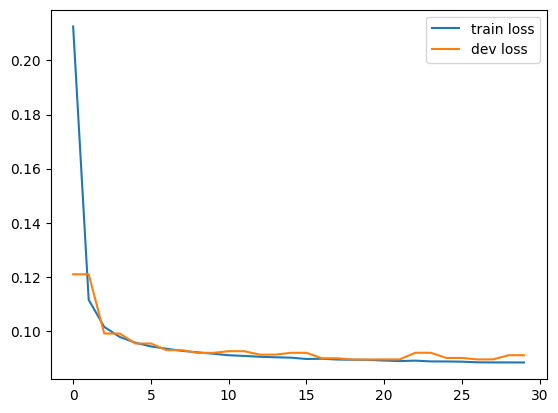

In [ ]:
# ploting
print(eval_autoencoder(dae_model, Xte, nn.BCELoss()))

plt.plot(dtrain_hist, label='train loss')
plt.plot(ddev_hist, label='dev loss')
plt.legend()
plt.show()

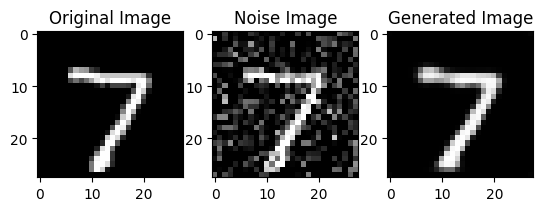

In [ ]:
# Select an image from the test set
img_index= 0
test_img= Xte[img_index:img_index+1]

a= NoiseAugment(sigma=0.25)
noise_img= a(test_img)

latent_vector, generated_img= dae_model(test_img)


# Plot the original image and the generated image
plt.subplot(1, 3, 1)
plt.imshow(test_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noise_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Noise Image')

plt.subplot(1, 3, 3)
plt.imshow(generated_img[0][0].cpu().detach().numpy(), cmap='gray')
plt.title('Generated Image')

plt.show()

In [ ]:
# https://medium.com/@ompramod9921/autoencoders-explained-9196c38af6f6
# https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/

# Variational Autoencoders

Variational Autoencoders (VAEs), which extend the capabilities of the traditional autoencoder framework by incorporating probabilistic elements into the encoding process. VAEs introduce a probabilistic approach where the encoder outputs a distribution over the latent space, typically modeled as a multivariate Gaussian. This allows VAEs to sample from this distribution during the decoding process, leading to the generation of new data instances.

VAEs are part of a family of generative models that learn a probability distribution over the input data, allowing them to generate new samples that are similar to the training data. In essence, VAEs learn to model the underlying probability distribution of the input data, which allows them to generate new data points that are similar to the training data.

VAEs use a loss function that combines two terms: a reconstruction loss, which measures the ability of the decoder to reconstruct the input from the latent space, and a regularization term, which measures the divergence between the learned distribution and a prior distribution over the latent space. The regularization term is usually implemented using the Kullback-Leibler divergence, which measures the difference between two probability distributions.

Therefore, the key innovation of VAEs lies in their ability to generate new, high-quality data by learning a structured, continuous latent space. This is particularly important for generative modeling, where the goal is not just to compress data but to create new data samples that resemble the original dataset.

In [ ]:
class VAE(Autoencoder):
    """
    Define the Variational Autoencoder model.
    """

    def __init__(self, image_size, input_chs, hidden_chs, output_chs, embedding_dim,
                 kernels=3, paddings=1, max_pools=2) -> None:
        super(VAE, self).__init__(image_size, input_chs, hidden_chs, output_chs, embedding_dim,
                                  kernels, paddings, max_pools)
        # define mu and log(variance) layers for reparameterization
        self.embedding_dim= embedding_dim
        self.mu= nn.Linear(embedding_dim, embedding_dim)
        self.log_var= nn.Linear(embedding_dim, embedding_dim)


    def reparameterize(self, mu, log_var):
        # compute the standard deviation from the log(variance)
        std= torch.exp(0.5 * log_var)
        # generate random noise using the same shape as std
        gen_noise= torch.randn_like(std)

        return mu + std * gen_noise # return the reparameterized sample


    def forward(self, x):
        encoded= self.encode(x)
        mu= self.mu(encoded)                # compute the mean and log(variance) vectors
        log_var= self.log_var(encoded)
        z= self.reparameterize(mu, log_var) # reparameterize the latent variable
        decoded= self.decode(z)

        return encoded, decoded, mu, log_var


In [ ]:
# autoencoder defs
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
embedding_dim= 64
kernels=3
paddings=1
max_pools=2

vae_model= VAE(image_size, input_chs, hidden_chs, output_chs, embedding_dim,
               kernels, paddings, max_pools).to(device)

total_params= sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

vae_model

Number of parameters: 489793


VAE(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ1): ReLU()
    (conv_hn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ2): ReLU()
    (conv_out): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (m_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activ3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc_out): Linear(in_features=1152, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc_in): Linear(in_features=64, out_features=1152, bias=True)
    (make2d): Unflatten(dim=1, unflattened_size=torch.Size([128, 3, 3]))
    (convT_in): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))


# Train the VAE

In [ ]:
class KLD_Loss(nn.Module):
    """
    Reconstruction + KL divergence losses summed over all elements and batch
    see Appendix B from VAE paper:
    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114
    """

    def __init__(self, reduction='sum') -> None:
        super().__init__()
        self.reduction= reduction


    def forward(self, recon_x, true_x, mu, log_var):
        # BCE loss between the reconstructed output and the input data
        BCE= F.binary_cross_entropy(recon_x, true_x, reduction=self.reduction)
        # KLD between the learned latent variable distribution and a std Gaussian distribution
        KLD= -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        if self.reduction=='mean':
            KLD /= true_x.shape[0]

        return BCE + KLD  # combine the two losses by adding them together


In [ ]:
def vae_autoencoder_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches:bool=True,
                             batch_size=64, shuffle:bool=True, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= math.floor(Xtr.shape[0]/ batch_size)
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= KLD_Loss().forward
    loss_ev_fn= nn.MSELoss()

    # for decreasing learning rate
    scheduler= ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.1, min_lr=1e-6)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    dev_hist= []
    schedule_hist= []

    # training data indexes
    ix= torch.arange(0, Xtr.shape[0])

    # --- training loop ---
    for epoch in tqdm(range(epochs)):

        batch_loss= []
        batch_schedule= []

        # iterating over all batches
        if shuffle:
            ix= torch.randperm(Xtr.shape[0])[:Xtr.shape[0]]

        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[ix[(i * batch_size) : ((i+1) * batch_size)]]

            # --- forward pass and get loss ---
            model.train(True)
            _, y_dec, mu, log_var= model(Xmb)
            loss_tr= loss_fn(y_dec, Xmb, mu, log_var)
            batch_loss.append(loss_tr.item() / Xmb.shape[0]) # KLD_Loss returns a sum by default

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                _, y_dec, mu, log_var= model(Xdev)
                loss_dev= loss_fn(y_dec, Xdev, mu, log_var)

        dev_hist.append(loss_dev.item() / Xdev.shape[0])
        schedule_hist.append(scheduler.get_last_lr())
        scheduler.step(train_hist[-1]) # step learning rate scheduler


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    return train_hist, dev_hist, schedule_hist


In [ ]:
# autoencoder defs
image_size= Xtr.shape[2]
input_chs= Xtr.shape[1]
hidden_chs= [32,64]
output_chs= 128
embedding_dim= 64
kernels=3
paddings=1
max_pools=2

vae_model= VAE(image_size, input_chs, hidden_chs, output_chs, embedding_dim,
               kernels, paddings, max_pools).to(device)

vae_train_hist, vae_dev_hist, vae_schedule_hist= vae_autoencoder_training(vae_model,
                                                               learning_rate=1e-3, epochs=30,
                                                               eval_interval=2, batch_size=250,
                                                               cutoff=1e-4)


100%|██████████| 30/30 [20:20<00:00, 40.69s/it]


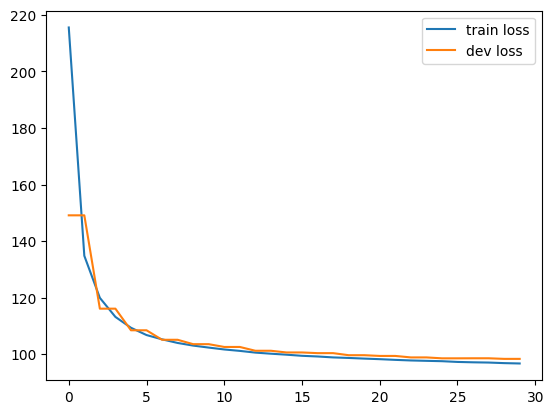

In [ ]:
# ploting

plt.plot(vae_train_hist, label='train loss')
plt.plot(vae_dev_hist, label='dev loss')
plt.legend()
plt.show()

In [ ]:
def gen_samples(model, num_samples):
    model.train(False)
    with torch.no_grad():
        # generate random noise
        z= torch.randn(num_samples, model.embedding_dim).to(device)
        samples= model.decode(z)

    return samples


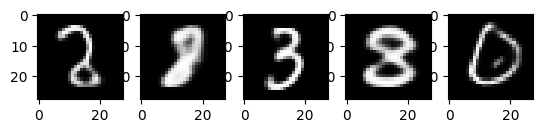

In [ ]:
samples= gen_samples(vae_model, 5)

f, axarr= plt.subplots(1, 5)

# original image - positive pair
for i in range(samples.shape[0]):
    axarr[i].imshow(samples[i][0].detach().cpu().numpy(), cmap='gray')

plt.show()

Variational Autoencoders (VAEs) have proven to be a groundbreaking advancement in the realm of machine learning and data generation.

While simple autoencoders can reconstruct images, they struggle with generating new data. Variational autoencoders (VAEs) offer a more flexible approach by learning parameters of a distribution of the latent space that can be sampled to generate new data. The re-parametrization trick is used to make the sampling operation differentiable. VAEs offer an improvement over simple autoencoders and have many applications, such as generative modelling, anomaly detection, and feature learning.

In [ ]:
# https://www.datacamp.com/tutorial/variational-autoencoders
# https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95